In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

# -----------------------------
# 配置：你的 Megalodon 模型路径
# -----------------------------
OBJ_PATH = "Megalodon.obj"   # 改成你的路径

def load_obj_vertices_faces(filename):
    """从 .obj 中读取 v 和 f，输出
       V: (N,3) 顶点坐标
       F: (M,3) 三角形顶点索引（0-based）
    """
    vertices = []
    faces = []
    with open(filename, "r") as f:
        for line in f:
            if line.startswith("v "):
                parts = line.strip().split()
                vertices.append([float(parts[1]), float(parts[2]), float(parts[3])])
            elif line.startswith("f "):
                parts = line.strip().split()[1:]
                # 支持  v   或  v/vt/vn  格式，只取第一个数字
                idx = [int(p.split("/")[0]) for p in parts]
                # 假定原始为三角形；如果是多边形可以做简单扇形三角剖分
                if len(idx) == 3:
                    faces.append(idx)
                elif len(idx) > 3:
                    # 扇形剖分: (0, i, i+1)
                    for i in range(1, len(idx) - 1):
                        faces.append([idx[0], idx[i], idx[i+1]])

    V = np.array(vertices, dtype=float)
    F = np.array(faces, dtype=int) - 1  # 转成 0-based
    return V, F

V_full, F_full = load_obj_vertices_faces(OBJ_PATH)

print("Full mesh:")
print("  Vertices:", V_full.shape)
print("  Faces   :", F_full.shape)

# 如果你已经有 CSV，可替换为：
# V_full = np.loadtxt("Megalodon_vertices.csv", delimiter=",", skiprows=1)
# F_full = np.loadtxt("Megalodon_faces.csv", delimiter=",", skiprows=1, dtype=int) - 1

Full mesh:
  Vertices: (499892, 3)
  Faces   : (1000000, 3)


In [4]:
# ---------- Full mesh topology check ----------

edges01 = F_full[:, [0, 1]]
edges12 = F_full[:, [1, 2]]
edges20 = F_full[:, [2, 0]]
edges_full = np.vstack((edges01, edges12, edges20))

# 每条边排序端点，使 (i,j) 与 (j,i) 视为同一条
edges_sorted_full = np.sort(edges_full, axis=1)

edge_keys_full, edge_counts_full = np.unique(edges_sorted_full,
                                             axis=0,
                                             return_counts=True)

boundary_edges_full = int(np.sum(edge_counts_full == 1))
nonmanifold_edges_full = int(np.sum(edge_counts_full > 2))

print("Full mesh topology check:")
print("  Boundary edges   :", boundary_edges_full)
print("  Non-manifold edges:", nonmanifold_edges_full)

if boundary_edges_full == 0:
    print("  ✅ Watertight (no open boundary)")
else:
    print("  ⚠ 有开放边界")

if nonmanifold_edges_full == 0:
    print("  ✅ Manifold (no non-manifold edges)")
else:
    print("  ⚠ 存在非流形边")

Full mesh topology check:
  Boundary edges   : 0
  Non-manifold edges: 0
  ✅ Watertight (no open boundary)
  ✅ Manifold (no non-manifold edges)


In [5]:
# ---------- Build uniform adjacency matrix for Taubin smoothing ----------

N = V_full.shape[0]
rows = []
cols = []

for tri in F_full:
    a, b, c = tri
    rows.extend([a, b, b, c, c, a])
    cols.extend([b, a, c, b, a, c])

data = np.ones(len(rows), dtype=float)
A = coo_matrix((data, (rows, cols)), shape=(N, N)).tocsr()

deg = np.array(A.sum(axis=1)).ravel()
deg[deg == 0] = 1.0  # 防止除零

def taubin_smooth_sparse(V, A, deg, iters=80, lam=0.5, mu=-0.53):
    """
    Taubin smoothing:
      V_{k+1} = V_k + λ·L(V_k)  再   V_{k+2} = V_{k+1} + μ·L(V_{k+1})
    这里的 L 用 uniform Laplacian: L(V) = (A V / deg - V)
    iters = λ+μ 一起算一次，所以总 smoothing 回合 = iters
    """
    V = V.copy()
    for _ in range(iters):
        # lambda step
        AV = A.dot(V)
        LV = AV / deg[:, None] - V
        V = V + lam * LV

        # mu step
        AV = A.dot(V)
        LV = AV / deg[:, None] - V
        V = V + mu * LV
    return V

V_taubin = taubin_smooth_sparse(V_full, A, deg, iters=80, lam=0.5, mu=-0.53)

print("Taubin smoothing done. V_taubin shape:", V_taubin.shape)

Taubin smoothing done. V_taubin shape: (499892, 3)


In [6]:
# ---------- Higher-resolution simplification (~2–3 万顶点) ----------

V = V_taubin
F = F_full

n_axis = 80  # 80^3 体素，大概 2~3 万 cluster

mins = V.min(axis=0)
maxs = V.max(axis=0)
extent = maxs - mins
extent[extent == 0] = 1.0  # 防止除零

# 归一化到 [0,1)，然后映射到 0..n_axis-1
norm = (V - mins) / extent
idx = np.floor(norm * n_axis).astype(int)
idx = np.clip(idx, 0, n_axis - 1)

# 每个顶点对应一个体素线性编号
lin_idx = idx[:, 0] + idx[:, 1] * n_axis + idx[:, 2] * n_axis * n_axis

unique_cells, inverse = np.unique(lin_idx, return_inverse=True)
K = unique_cells.shape[0]

# 聚类平均每个cell内的顶点坐标
counts = np.bincount(inverse)
V30 = np.zeros((K, 3), dtype=float)
for d in range(3):
    V30[:, d] = np.bincount(inverse, weights=V[:, d]) / counts

# 重映射面索引
F30 = inverse[F]

# 去掉退化三角形
mask_non_deg = (F30[:, 0] != F30[:, 1]) & (F30[:, 1] != F30[:, 2]) & (F30[:, 0] != F30[:, 2])
F30 = F30[mask_non_deg]

print("Simplified mesh (for curvature / TetWild):")
print("  Vertices:", V30.shape)
print("  Faces   :", F30.shape)

Simplified mesh (for curvature / TetWild):
  Vertices: (22093, 3)
  Faces   : (46970, 3)


In [7]:
# ---------- Orient faces consistently outward (approx) ----------

C30 = V30.mean(axis=0)   # 整体质心：用来判断“外侧”
v0 = V30[F30[:, 0]]
v1 = V30[F30[:, 1]]
v2 = V30[F30[:, 2]]

normals30 = np.cross(v1 - v0, v2 - v0)
centers30 = (v0 + v1 + v2) / 3.0
dirs30 = centers30 - C30

dots30 = np.einsum("ij,ij->i", normals30, dirs30)
flip_mask30 = dots30 < 0

# 将需要翻转的三角形交换第二、第三个顶点
tmp = F30[flip_mask30, 1].copy()
F30[flip_mask30, 1] = F30[flip_mask30, 2]
F30[flip_mask30, 2] = tmp

print("Face orientation unified (outward w.r.t mesh centroid).")

Face orientation unified (outward w.r.t mesh centroid).


Curvature arrays:
  K_gauss shape     : (22093,)
  H_mean_magnitude  : (22093,)


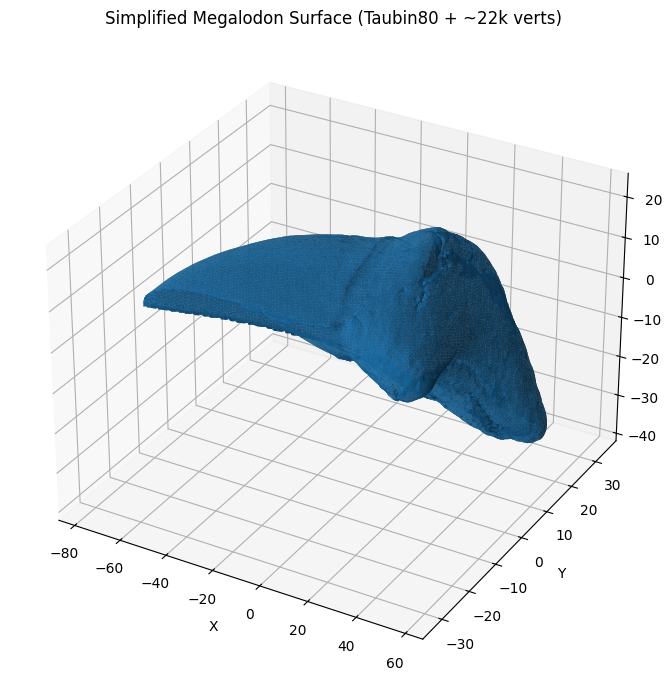

In [8]:
# ---------- Curvature analysis (Gaussian + mean curvature magnitude) ----------

nV = V30.shape[0]
nF = F30.shape[0]

p0 = V30[F30[:, 0]]
p1 = V30[F30[:, 1]]
p2 = V30[F30[:, 2]]

# 从各顶点出发的两条边向量
u0 = p1 - p0
v0 = p2 - p0
u1 = p2 - p1
v1 = p0 - p1
u2 = p0 - p2
v2 = p1 - p2

def angle_between(u, v):
    uu = np.linalg.norm(u, axis=1)
    vv = np.linalg.norm(v, axis=1)
    denom = uu * vv
    denom[denom == 0] = 1e-12
    cosang = np.einsum("ij,ij->i", u, v) / denom
    cosang = np.clip(cosang, -1.0, 1.0)
    return np.arccos(cosang)

ang0 = angle_between(u0, v0)
ang1 = angle_between(u1, v1)
ang2 = angle_between(u2, v2)

# 面面积
face_normals = np.cross(p1 - p0, p2 - p0)
face_areas = 0.5 * np.linalg.norm(face_normals, axis=1)

# 顶点角度和 & 顶点面积（1/3 分摊每个三角形到三个顶点）
angle_sum = np.zeros(nV)
area_sum = np.zeros(nV)

angle_sum += np.bincount(F30[:, 0], weights=ang0, minlength=nV)
angle_sum += np.bincount(F30[:, 1], weights=ang1, minlength=nV)
angle_sum += np.bincount(F30[:, 2], weights=ang2, minlength=nV)

area_sum += np.bincount(F30[:, 0], weights=face_areas / 3.0, minlength=nV)
area_sum += np.bincount(F30[:, 1], weights=face_areas / 3.0, minlength=nV)
area_sum += np.bincount(F30[:, 2], weights=face_areas / 3.0, minlength=nV)

area_safe = np.where(area_sum == 0, 1e-12, area_sum)

K_gauss = (2.0 * np.pi - angle_sum) / area_safe  # 高斯曲率

# Mean curvature via uniform Laplacian
rows = []
cols = []
for tri in F30:
    a, b, c = tri
    rows.extend([a, b, b, c, c, a])
    cols.extend([b, a, c, b, a, c])

data = np.ones(len(rows), dtype=float)
A30 = coo_matrix((data, (rows, cols)), shape=(nV, nV)).tocsr()
deg30 = np.array(A30.sum(axis=1)).ravel()
deg30[deg30 == 0] = 1.0

AV30 = A30.dot(V30)
L30 = AV30 / deg30[:, None] - V30
H_mean_mag = 0.5 * np.linalg.norm(L30, axis=1)

print("Curvature arrays:")
print("  K_gauss shape     :", K_gauss.shape)
print("  H_mean_magnitude  :", H_mean_mag.shape)

# 只做一个几何可视化：simplified Megalodon surface
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection="3d")

# 直接用 trisurf 看 simplified megalodon surface
ax.plot_trisurf(V30[:, 0], V30[:, 1], V30[:, 2],
                triangles=F30,
                linewidth=0.05,
                antialiased=True,
                shade=True,
                edgecolor="none",
                alpha=0.95)

ax.set_title("Simplified Megalodon Surface (Taubin80 + ~22k verts)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.tight_layout()
plt.show()

In [9]:
# ========== Export functions ==========

def export_stl_ascii(path, V, F):
    """ASCII STL export"""
    with open(path, "w") as f:
        f.write("solid mesh\n")
        for tri in F:
            p0, p1, p2 = V[tri]
            n = np.cross(p1 - p0, p2 - p0)
            n = n / (np.linalg.norm(n) + 1e-12)
            f.write(f"  facet normal {n[0]} {n[1]} {n[2]}\n")
            f.write("    outer loop\n")
            for p in (p0, p1, p2):
                f.write(f"      vertex {p[0]} {p[1]} {p[2]}\n")
            f.write("    endloop\n")
            f.write("  endfacet\n")
        f.write("endsolid mesh\n")


def export_ply(path, V, F):
    """PLY (ASCII) export"""
    with open(path, "w") as f:
        f.write("ply\nformat ascii 1.0\n")
        f.write(f"element vertex {V.shape[0]}\n")
        f.write("property float x\nproperty float y\nproperty float z\n")
        f.write(f"element face {F.shape[0]}\n")
        f.write("property list uchar int vertex_indices\n")
        f.write("end_header\n")
        for p in V:
            f.write(f"{p[0]} {p[1]} {p[2]}\n")
        for tri in F:
            f.write(f"3 {tri[0]} {tri[1]} {tri[2]}\n")


def export_msh(path, V, F):
    """Gmsh v2 ASCII mesh (surface-only)"""
    with open(path, "w") as f:
        f.write("$MeshFormat\n2.2 0 8\n$EndMeshFormat\n")
        f.write("$Nodes\n")
        f.write(f"{V.shape[0]}\n")
        for i, p in enumerate(V, start=1):
            f.write(f"{i} {p[0]} {p[1]} {p[2]}\n")
        f.write("$EndNodes\n")

        f.write("$Elements\n")
        f.write(f"{F.shape[0]}\n")
        for i, tri in enumerate(F, start=1):
            f.write(f"{i} 2 2 1 1 {tri[0]+1} {tri[1]+1} {tri[2]+1}\n")
        f.write("$EndElements\n")


# ---- Export all three formats ----
export_stl_ascii("Megalodon_simplified.stl", V30, F30)
export_ply("Megalodon_simplified.ply", V30, F30)
export_msh("Megalodon_simplified.msh", V30, F30)

print("Exported: STL / PLY / MSH ✓")

Exported: STL / PLY / MSH ✓


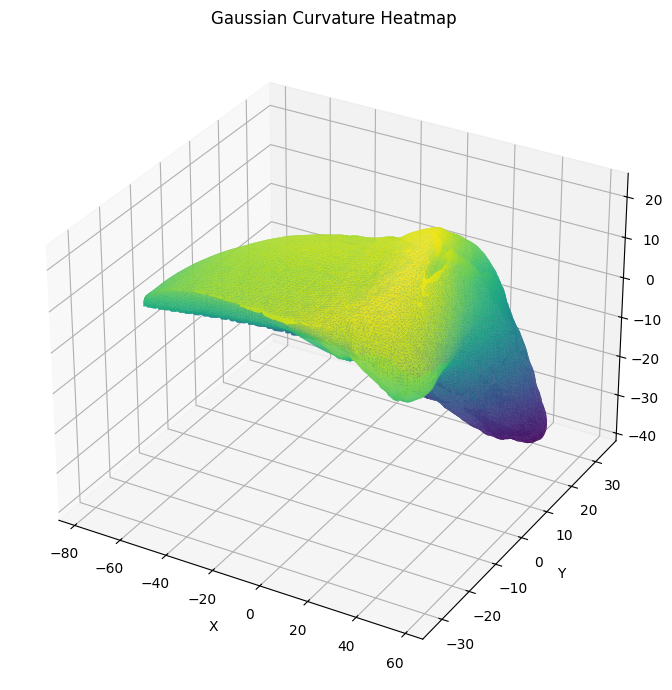

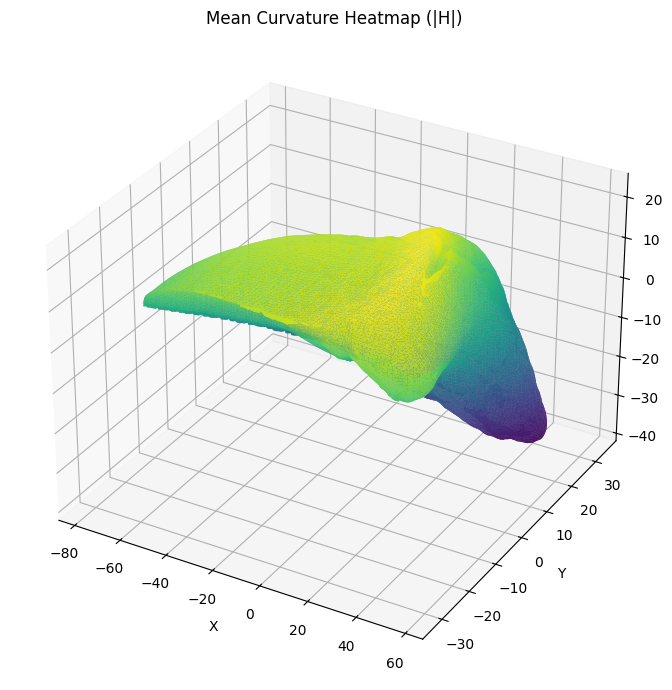

In [10]:
# -------- Heatmap visualization on simplified surface ----------
from matplotlib import cm

def plot_surface_color(V, F, values, title):
    fig = plt.figure(figsize=(8,7))
    ax = fig.add_subplot(111, projection="3d")

    ax.plot_trisurf(
        V[:, 0], V[:, 1], V[:, 2],
        triangles=F,
        linewidth=0.2,
        antialiased=True,
        cmap=cm.viridis,
        shade=False,
        edgecolor="none",
        alpha=0.95,
        facecolors=cm.viridis((values - values.min()) /
                              (values.max() - values.min() + 1e-12))
    )
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.tight_layout()
    plt.show()


plot_surface_color(V30, F30, K_gauss, "Gaussian Curvature Heatmap")
plot_surface_color(V30, F30, H_mean_mag, "Mean Curvature Heatmap (|H|)")

In [11]:
# -------- Prepare TetWild input OBJ --------
with open("tetwild_input.obj", "w") as f:
    for p in V30:
        f.write(f"v {p[0]} {p[1]} {p[2]}\n")
    for tri in F30:
        f.write(f"f {tri[0]+1} {tri[1]+1} {tri[2]+1}\n")

print("TetWild input OBJ generated: tetwild_input.obj ✓")

TetWild input OBJ generated: tetwild_input.obj ✓


In [12]:
import numpy as np
import pytetwild

# Input: your cleaned / simplified Megalodon surface
V_in = V30.astype(np.float64)
F_in = F30.astype(np.int32)

print("Running TetWild refinement and tetrahedralization…")

V_tet, T_tet = pytetwild.tetrahedralize(V_in, F_in)

print("TetWild tetrahedral mesh generated ✓")
print("  Vertices:", V_tet.shape)
print("  Tets    :", T_tet.shape)

Running TetWild refinement and tetrahedralization…
Starting tetrahedralization process...
Starting tetrahedralization...
Tetrahedralization complete.
Number of vertices: 15993
Number of tetrahedra: 66250
Prepared numpy array for points.
Prepared numpy array for tetrahedra.
Tetrahedralization process completed successfully.
TetWild tetrahedral mesh generated ✓
  Vertices: (15993, 3)
  Tets    : (66250, 4)
Loading mesh...
Loaded mesh data into GEO::Mesh.
Initialized AABBWrapper.
Created Mesh instance for output.
bbox_diag_length = 163.253
ideal_edge_length = 8.16266
stage = 2
eps_input = 0.163253
eps = 0.0903753
eps_simplification = 0.0723003
eps_coplanar = 0.000163253
dd = 0.108835
dd_simplification = 0.0870684
[2025-11-21 20:51:23.663] [float-tetwild] [info] remove duplicates: 
[2025-11-21 20:51:23.663] [float-tetwild] [info] #v: 22093 -> 22093
[2025-11-21 20:51:23.663] [float-tetwild] [info] #f: 46970 -> 44810
collapsing 0.984762
swapping 0.0267718
[2025-11-21 20:51:24.698] [float-tet

23
max_energy = 17.9451
avg_energy = 3.63585
//////////////// pass 38 ////////////////
edge splitting...
fixed 0 tangled element
success = 1797(1797)
edge splitting done!
time = 0.0834539s
#v = 29642
#t = 162368
max_energy = 24.8855
avg_energy = 3.68034
edge collapsing...
fixed 0 tangled element
success(env) = 103
success = 1702(297153)
success(env) = 4
success = 79(7108)
success(env) = 3
success = 14(883)
success(env) = 0
success = 3(285)
success(env) = 0
success = 1(16)
success(env) = 0
success = 0(5)
edge collapsing done!
time = 0.804025s
#v = 27843
#t = 154649
max_energy = 17.9451
avg_energy = 3.64399
edge swapping...
fixed 0 tangled element
success3 = 39
success4 = 317
success5 = 23
success = 379(110406)
edge swapping done!
time = 0.483829s
#v = 27843
#t = 154633
max_energy = 14.8492
avg_energy = 3.64043
vertex smoothing...
success = 18638(26034)
vertex smoothing done!
time = 0.114734s
#v = 27843
#t = 154633
max_energy = 12.2426
avg_energy = 3.6324
//////////////// pass 39 ///////

In [38]:
import pyvista as pv
import numpy as np

# -------------------------
# Convert surface mesh
# -------------------------
# PolyData requires the VTK face format: [n, i0, i1, i2]
faces_vtk = np.hstack(
    [np.full((F_in.shape[0], 1), 3, dtype=np.int32), F_in]
).ravel()

surface_mesh = pv.PolyData(V_in, faces_vtk)


# -------------------------
# Convert tetrahedral mesh
# -------------------------
# UnstructuredGrid requires an offset + cell type array
# VTK tetra type = 10
num_tets = T_tet.shape[0]
cells = np.hstack(
    [np.full((num_tets, 1), 4, dtype=np.int32), T_tet]
).ravel()

celltypes = np.full(num_tets, 10, dtype=np.uint8)

tetrahedral_mesh = pv.UnstructuredGrid(cells, celltypes, V_tet)


# -------------------------
# PyVista visualization
# -------------------------
p = pv.Plotter(shape=(1, 2), border=False)

# --- Left: Input surface mesh ---
p.subplot(0, 0)
p.add_text("Input Surface Mesh", font_size=12)

p.add_mesh(
    surface_mesh,
    color="white",
    opacity=0.25,        # semi-transparent
    show_edges=True,
    edge_color="black",  
    line_width=0.3,      # extremely thin edge lines
    lighting=True,
    smooth_shading=True
)

# --- Right: TetWild tetrahedral mesh ---
p.subplot(0, 1)
p.add_text("TetWild Tetrahedral Mesh", font_size=12)

p.add_mesh(
    tetrahedral_mesh,
    color="lightblue",
    opacity=0.18,        # slightly more transparent for volume
    show_edges=True,
    edge_color="navy",
    line_width=0.25,     # even thinner edges for dense tets
    lighting=True,
    smooth_shading=True
)

# Sync cameras
p.link_views()
p.disable_parallel_projection()

p.show()

Widget(value='<iframe src="http://localhost:55689/index.html?ui=P_0x13a2de990_1&reconnect=auto" class="pyvista…

In [14]:
def write_msh(V, T, filename="Megalodon_tetwild.msh"):
    with open(filename, "w") as f:
        f.write("$MeshFormat\n2.2 0 8\n$EndMeshFormat\n")

        # Nodes
        f.write("$Nodes\n")
        f.write(f"{len(V)}\n")
        for i,(x,y,z) in enumerate(V, start=1):
            f.write(f"{i} {x} {y} {z}\n")
        f.write("$EndNodes\n")

        # Elements (4-node tetrahedra -> type 4)
        f.write("$Elements\n")
        f.write(f"{len(T)}\n")
        for i,(a,b,c,d) in enumerate(T+1, start=1):
            f.write(f"{i} 4 0 {a} {b} {c} {d}\n")
        f.write("$EndElements\n")

    print(f"Saved Gmsh file: {filename} ✓")

write_msh(V_tet, T_tet)

Saved Gmsh file: Megalodon_tetwild.msh ✓


In [15]:
import meshio

meshio.write_points_cells(
    "Megalodon_tetwild.vtk",
    V_tet,
    {"tetra": T_tet}
)

print("Saved VTK for Paraview ✓")

Saved VTK for Paraview ✓


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

# -----------------------------
# 输入文件：你的 Taubin80 平滑结果
# -----------------------------
# save V_30 and F_30 in npz format in Megalodon_vertices_taubin80.csv and Megalodon_faces.csv
import numpy as np
import os, zipfile, tempfile

def safe_npz_write(path, **arrays):
    """Safe NPZ writer that avoids NumPy compression bugs on macOS/Python 3.13."""
    path = os.path.abspath(path)
    folder = os.path.dirname(path)
    if folder and not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)

    tmp = path + ".tmp"

    try:
        # write manually as ZIP
        with zipfile.ZipFile(tmp, "w", zipfile.ZIP_DEFLATED) as zf:
            for name, arr in arrays.items():
                arr = np.asarray(arr)
                # store as NPY inside the zip
                with zf.open(name + ".npy", "w") as f:
                    np.save(f, arr)
    except Exception as e:
        raise RuntimeError(f"Error during NPZ write: {e}")

    if not os.path.exists(tmp):
        raise RuntimeError("Temp NPZ was not created — write failed.")

    os.replace(tmp, path)


# ------------------------------------------------------------
# Usage
# ------------------------------------------------------------

safe_npz_write(
    "/Users/eliguli712/DataStructure/numerical_analysis/FEA_meg/Megalodon_mesh_backup.npz",
    V=V30,
    F=F30
)

V_full = np.loadtxt("Megalodon_vertices_taubin80.csv", delimiter=",", skiprows=1)
F_full = np.loadtxt("Megalodon_faces.csv", delimiter=",", skiprows=1, dtype=int) - 1

print("Loaded Taubin80 smoothed full mesh:")
print("  Vertices:", V_full.shape)
print("  Faces   :", F_full.shape)

Loaded Taubin80 smoothed full mesh:
  Vertices: (22093, 3)
  Faces   : (46970, 3)


In [17]:
# ---------- Construct edges ----------
edges01 = F_full[:, [0, 1]]
edges12 = F_full[:, [1, 2]]
edges20 = F_full[:, [2, 0]]
edges_full = np.vstack((edges01, edges12, edges20))

edges_sorted = np.sort(edges_full, axis=1)
edge_keys, edge_counts = np.unique(edges_sorted, axis=0, return_counts=True)

boundary_edges_full = int(np.sum(edge_counts == 1))
nonmanifold_edges_full = int(np.sum(edge_counts > 2))

print("Full-resolution mesh topology check:")
print("  boundary edges   =", boundary_edges_full)
print("  non-manifold edges =", nonmanifold_edges_full)

Full-resolution mesh topology check:
  boundary edges   = 0
  non-manifold edges = 3285


In [18]:
def voxel_simplify(V, F, n_axis=80):
    mins = V.min(axis=0)
    maxs = V.max(axis=0)
    extent = maxs - mins
    extent[extent == 0] = 1.0

    norm = (V - mins) / extent
    idx = np.floor(norm * n_axis).astype(int)
    idx = np.clip(idx, 0, n_axis-1)

    lin_idx = idx[:, 0] + idx[:, 1]*n_axis + idx[:, 2]*(n_axis*n_axis)

    unique_cells, inverse = np.unique(lin_idx, return_inverse=True)
    K = unique_cells.shape[0]

    # 生成聚类顶点
    V_new = np.zeros((K, 3))
    counts = np.bincount(inverse)

    for d in range(3):
        V_new[:, d] = np.bincount(inverse, weights=V[:, d]) / counts

    # 重新映射面
    F_new = inverse[F]

    # 删除退化面
    mask = (F_new[:,0]!=F_new[:,1]) & (F_new[:,1]!=F_new[:,2]) & (F_new[:,0]!=F_new[:,2])
    return V_new, F_new[mask]

V30, F30 = voxel_simplify(V_full, F_full, n_axis=80)

print("Simplified mesh:")
print("  Vertices:", V30.shape)
print("  Faces   :", F30.shape)

Simplified mesh:
  Vertices: (20199, 3)
  Faces   : (45334, 3)


#### Self Topology Check

In [19]:
edges01 = F30[:, [0, 1]]
edges12 = F30[:, [1, 2]]
edges20 = F30[:, [2, 0]]
edges = np.vstack((edges01, edges12, edges20))

edges_sorted = np.sort(edges, axis=1)
ek, ec = np.unique(edges_sorted, axis=0, return_counts=True)

boundary_edges_30 = int(np.sum(ec == 1))
nonmanifold_edges_30 = int(np.sum(ec > 2))

print("Simplified mesh topology check:")
print("  boundary edges   =", boundary_edges_30)
print("  non-manifold edges =", nonmanifold_edges_30)

Simplified mesh topology check:
  boundary edges   = 0
  non-manifold edges = 3306


#### Numerical Methods to Gaussian Curvature ($K$) and Average Curvature ($H$)
##### Mixed Voronoi Area (DDG)
1) Vertex traversal, for each triangular tile $T_j = (v_1, v_2, v_3)$, compute the side-lengths and the triangular areas, where
$$
L_{12}^2 = ||v_1 - v_2||_2^2, \quad L_{23}^2 = ||v_2 - v_3||_2^2, \quad L_{13}^2 = ||v_1 - v_3||_2^2\\
A_{f} = \frac{L_{12}\times L_{13}}{2}
$$
2) Validate the types of the triangles: obtuse/acute
3) Assign areas $A_{f}$ to the respective Voronoi areas $A_i$ to three adjacent vertices $v_1, v_2, v_3$ by types of triangles

Specifically, if the angles are acute $\theta \in [0, \frac{\pi}{2})$
$$
\alpha = \frac{L_{12} \times L_{13}}{||L_{12}||_2||L_{13}||_2}, \quad \beta = \frac{L_{12} \times L_{23}}{||L_{12}||_2||L_{23}||_2}, \quad \gamma = \frac{L_{13} \times L_{23}}{||L_{13}||_2||L_{23}||_2}\\
A_{v_1} = \frac{L_{13}^2 \cot(\beta) + L_{12}^2 \cot(\gamma)}{8}, \\
A_{v_2} = \frac{L_{12}^2 \cot(\gamma) + L_{23}^2 \cot(\alpha)}{8}, \\
A_{v_3} = \frac{L_{23}^2 \cot(\alpha) + L_{13}^2 \cot(\beta)}{8}, \\
\cot(\alpha) = \frac{L_{12}^2 + L_{13}^2 - L_{23}^2}{4 \dot A_{f}}, \quad
\cot(\beta) = \frac{L_{12}^2 + L_{23}^2 - L_{13}^2}{4 \dot A_{f}}, \quad
\cot(\gamma) = \frac{L_{13}^2 + L_{23}^2 - L_{12}^2}{4 \dot A_{f}}
$$
If the angles are obtuse then $A_{v_1} = A_{v_2} = A_{v_3} = \frac{A_{f}}{3}$

##### Compute Gaussian Curvature ($K_i$)
$
K_i = \frac{2\pi - \sum_{j} \theta_{ij}}{A_i}
$
, where $\sum_{j} \theta_{ij} = \alpha_i + \beta_i + \gamma_i$
##### Compute Average Curvature ($H_i$)
$$ H_i = \frac{1}{2 A_i} ||\sum_{j} \frac{\cot(\alpha_{ij}) + \cot(\beta_{ij})}{2} (p_i - p_j)||_2 $$
##### Principle Curvatures ($K = k_1 \cdot k_2$)
$k_{1,2} = H \pm \sqrt{H^2 - K}$

In [ ]:
import numpy as np

# Helper: Compute face angles
def angle(a, b, c):
    u = b - a
    v = c - a
    cosang = np.sum(u * v, axis=1) / (
        np.linalg.norm(u, axis=1) * np.linalg.norm(v, axis=1) + 1e-15
    )
    return np.arccos(np.clip(cosang, -1.0, 1.0))

def mixed_voronoi(V, F):
    """
    Compute mixed Voronoi area per vertex for a triangulated surface mesh.
    Meyer–Desbrun–Schröder–Barr (2003) formula.
    """
    V = np.asarray(V)
    F = np.asarray(F)

    # Face vertex positions
    v0 = V[F[:, 0]]
    v1 = V[F[:, 1]]
    v2 = V[F[:, 2]]

    # Edge vectors
    e0 = v1 - v0  # edge v0→v1
    e1 = v2 - v1  # edge v1→v2
    e2 = v0 - v2  # edge v2→v0 (note sign is ok)

    # Opposite edge lengths
    l0 = np.linalg.norm(e0, axis=1)
    l1 = np.linalg.norm(e1, axis=1)
    l2 = np.linalg.norm(e2, axis=1)

    A0 = angle(v0, v1, v2)
    A1 = angle(v1, v2, v0)
    A2 = angle(v2, v0, v1)

    # Triangle area
    face_area = 0.5 * np.linalg.norm(np.cross(e0, e2), axis=1)

    # Detect obtuse triangles
    obt0 = A0 > np.pi/2
    obt1 = A1 > np.pi/2
    obt2 = A2 > np.pi/2
    any_obt = obt0 | obt1 | obt2

    # Cotangents (used if triangle is non-obtuse)
    cot0 = 1 / np.tan(A0)
    cot1 = 1 / np.tan(A1)
    cot2 = 1 / np.tan(A2)

    # Mixed Voronoi per face, contributions to v0, v1, v2
    area0 = np.zeros(len(F))
    area1 = np.zeros(len(F))
    area2 = np.zeros(len(F))

    # Case 1: non-obtuse triangle → use standard cotangent Voronoi
    mask = ~any_obt
    area0[mask] = (l2[mask]**2 * cot1[mask] + l1[mask]**2 * cot2[mask]) * 0.125
    area1[mask] = (l0[mask]**2 * cot2[mask] + l2[mask]**2 * cot0[mask]) * 0.125
    area2[mask] = (l1[mask]**2 * cot0[mask] + l0[mask]**2 * cot1[mask]) * 0.125

    # Case 2: obtuse triangle → area split special-case
    area0[obt0] = face_area[obt0] * 0.5
    area1[obt0] = face_area[obt0] * 0.25
    area2[obt0] = face_area[obt0] * 0.25

    area1[obt1] = face_area[obt1] * 0.5
    area2[obt1] = face_area[obt1] * 0.25
    area0[obt1] = face_area[obt1] * 0.25

    area2[obt2] = face_area[obt2] * 0.5
    area0[obt2] = face_area[obt2] * 0.25
    area1[obt2] = face_area[obt2] * 0.25

    # Assemble per-vertex Voronoi area
    A = np.zeros(len(V))
    np.add.at(A, F[:, 0], area0)
    np.add.at(A, F[:, 1], area1)
    np.add.at(A, F[:, 2], area2)

    return A

def gaussian_curvature(V, F):
    """
    Compute Gaussian curvature (angle deficit) per vertex
    using mixed Voronoi areas (Meyer et al. 2003).
    """
    V = np.asarray(V)
    F = np.asarray(F)

    # Face vertex positions
    p0 = V[F[:, 0]]
    p1 = V[F[:, 1]]
    p2 = V[F[:, 2]]

    A0 = angle(p0, p1, p2)
    A1 = angle(p1, p2, p0)
    A2 = angle(p2, p0, p1)

    # ----- accumulate per-vertex angle sums -----
    angle_sum = np.zeros(len(V))
    np.add.at(angle_sum, F[:, 0], A0)
    np.add.at(angle_sum, F[:, 1], A1)
    np.add.at(angle_sum, F[:, 2], A2)

    # ----- per-vertex Voronoi area -----
    A_mixed = mixed_voronoi(V, F)

    # ----- Gaussian curvature -----
    K = (2 * np.pi - angle_sum) / (A_mixed + 1e-12)

    return K

def average_curvature(V, F):
    """
    Mean curvature magnitude per vertex using the cotangent Laplacian.
    From Meyer et al. 2003 (the standard discrete differential geometry formula).
    """
    V = np.asarray(V, float)
    F = np.asarray(F, int)

    # Face vertex positions
    p0 = V[F[:, 0]]
    p1 = V[F[:, 1]]
    p2 = V[F[:, 2]]

    # Edge vectors
    e0 = p2 - p1   # opposite p0
    e1 = p0 - p2   # opposite p1
    e2 = p1 - p0   # opposite p2

    # Compute cotangents
    def cotangent(u, v):
        cross = np.linalg.norm(np.cross(u, v), axis=1)
        dot   = np.sum(u * v, axis=1)
        return dot / (cross + 1e-15)

    cot0 = cotangent(p1 - p0, p2 - p0)
    cot1 = cotangent(p2 - p1, p0 - p1)
    cot2 = cotangent(p0 - p2, p1 - p2)

    # Mixed Voronoi area per vertex (Meyer et al.)
    A = mixed_voronoi(V, F)

    # Accumulate Laplacian (cotangent-weighted)
    L = np.zeros_like(V)

    # For each face, accumulate contributions for the three vertices
    for i, tri in enumerate(F):
        i0, i1, i2 = tri
        c0, c1, c2 = cot0[i], cot1[i], cot2[i]

        # Laplace-Beltrami operator contributions
        L[i0] += (c1 * (V[i2] - V[i0]) + c2 * (V[i1] - V[i0]))
        L[i1] += (c2 * (V[i0] - V[i1]) + c0 * (V[i2] - V[i1]))
        L[i2] += (c0 * (V[i1] - V[i2]) + c1 * (V[i0] - V[i2]))

    # Mean curvature normal: Hn = 1/(2A) L
    H_normal = L / (2.0 * A[:, None] + 1e-15)

    # Mean curvature magnitude |H|
    H_mean_mag = np.linalg.norm(H_normal, axis=1)

    return H_mean_mag

def principal_curvatures(V, F):
    """
    Compute principal curvature magnitudes k1, k2 per vertex.

    Uses:
      - K: Gaussian curvature from angle deficit / mixed Voronoi
      - H: mean curvature magnitude from cotangent Laplacian

    Note: average_curvature currently returns |H|, so k1, k2 are
    magnitudes (non-signed) consistent with |H| and K.
    """
    K = gaussian_curvature(V, F)      # Gaussian curvature per vertex
    H = average_curvature(V, F)       # mean curvature magnitude per vertex

    # Discriminant: H^2 - K, clipped for numerical safety
    disc = H * H - K
    disc = np.clip(disc, 0.0, None)

    sqrt_disc = np.sqrt(disc)
    k1 = H + sqrt_disc
    k2 = H - sqrt_disc

    return k1, k2
    

#### Metric Diffusion Process (Renderer)
$X_t = \lambda L(X)$

##### Uniform Laplacian Smoothing
$L(x_i) = \frac{1}{m} \sum_{j \in N(v_i)} (x_j - x_i)$, 

Euler Scheme
$$
X^{n+1} = (1 + \lambda \mathbb{d}tL)X^n, \quad (1 - \lambda \mathbb{d}tL)X^{n+1} = X^n
$$

$$
v_{i}^{'} = v_{i} + \lambda \sum_{j \in N(v_i)} \frac{1}{N} (v_j - v_i), \\
v_{i}^{'} = \frac{\lambda}{N} \sum_{j \in N(v_i)} v_j + (1 - \lambda) v_i
$$

##### Cotangent Laplacian Smoothing
$$
v_{i}^{'} = v_{i} + \lambda \sum_{j \in N(v_i)} w_{ij}(v_j - v_i)
$$

##### Taubin Boundary Smoothing (TBV)
For adjacency matrix $A \in \mathbf{R}^{n \times n}$ (1 for neighbours) and vertex positions $V \in \mathbf{R}^{n \times 3}$

Define the uniform Laplacian $L(V) = \frac{AV}{\mathbb{deg}} - V$, 

where $\mathbb{deg}(i)$ is the degree of row $i$, $\mathbb{deg}(i) = \sum_{j} A_{ij}$, define the degree normalized adjacency $\widetilde{A} = D^{-1} A$ where $D = \mathbb{diag}(\mathbb{deg}(i))$

Laplacian $L = \widetilde{A} - I$

Iteration Step:
$$
V_{k+1} = V_k + \lambda (\widetilde{A} - I) V_k = ((1 - \lambda)I + \lambda \widetilde{A})V_k
$$
Taubin Smoothing Iteration ($\lambda$-step then $\mu$-step):
$$
V^{'} = [(1 - \lambda)I + \lambda \widetilde{A}]V_k, \\
V_{k+1} = [(1 - \mu)I + \mu \widetilde{A}]V^{'}
$$
Combined Taubin Operator:
$$
S = (1 - \lambda)(1 - \mu)I + [\lambda(1-\mu) + \mu(1-\lambda)]\widetilde{A} + \lambda \mu \widetilde{A}^{2}
$$
Taubin Smoothing: $V_k = S^k V_0$

Since $\widetilde{A}$ is diagonalizable through generalized eigendecomposition:
$\widetilde{A} = Q \Lambda Q^{-1}$, $\Lambda = \mathbb{diag}(\lambda_i)$ as eigenvalues.

Then: $S = Q g(\Lambda) Q^{-1}$

where $g(\Lambda_i)$ is the Taubin Spectral Response:
$$g(\Lambda_i) = (1 - \lambda)(1 - \mu) + [\lambda(1 - \mu) + \mu(1-\lambda)]\lambda_i + \lambda \mu \lambda_i^2$$
$V_k = Q g(\Lambda)^k Q^{-1} V_0$ with each eigenmode scaled independently

##### Spectral Response Function $g(\lambda)$
Define the quadratic spectral frequency $(\lambda)$ polynomial $g(\lambda)$
$$g(\lambda) = (1 - \lambda)(1 - \mu) + [\lambda(1 - \mu)+\mu(1-\lambda)]\lambda + \lambda \mu \lambda^2 = a_0 + a_1 \lambda + a_2 \lambda^2$$
$g(0) = 1, g(\lambda) < 1$ for volume preservation and smoothing, low frequency preserved, high frequencies suppressed

##### Shrinkage Avision
Singular Laplacian Smoothing Operator: $S_{L} = (1 - \lambda)I + \lambda \widetilde{A}$ with spectral response $g_{L}(\lambda_i) = 1 - \lambda (1 - \lambda_i)$, $1 - \lambda_i > 0$, every eigenmode shrinks (including zero-frequency), which collapses the mesh

Low-pass $(\lambda > 0)$: smooths high frequencies

High-pass / inflation $(\mu < 0)$: re-expands low frequencies

Thus the combined spectrum: $g(0) = 1$

Spectral filter applied:
$$
g(\lambda) = 1 + (\lambda + \mu)(\lambda_i - 1) + \lambda \mu (\lambda_i - 1)^2
$$
per eigen-frequency $\lambda_i = \mathbb{eig}(\widetilde{A})$

In [ ]:
# import numpy as np
# from scipy.sparse import coo_matrix

# # =============================================================
# #   1. GAUSSIAN CURVATURE (ANGLE DEFICIT METHOD)
# # =============================================================

# # Face vertices
# p0 = V30[F30[:, 0]]
# p1 = V30[F30[:, 1]]
# p2 = V30[F30[:, 2]]

# def tri_angle(a, b, c):
#     """
#     Angle at vertex b in triangle (a, b, c).
#     """
#     ba = a - b
#     bc = c - b
#     dot = np.einsum("ij,ij->i", ba, bc)
#     n1  = np.linalg.norm(ba, axis=1)
#     n2  = np.linalg.norm(bc, axis=1)
#     cosv = dot / (n1 * n2 + 1e-15)
#     return np.arccos(np.clip(cosv, -1.0, 1.0))

# # Angles at each corner
# ang0 = tri_angle(p1, p0, p2)  # at p0
# ang1 = tri_angle(p2, p1, p0)  # at p1
# ang2 = tri_angle(p0, p2, p1)  # at p2

# # Face areas
# face_normals = np.cross(p1 - p0, p2 - p0)
# face_areas   = 0.5 * np.linalg.norm(face_normals, axis=1)

# nV = V30.shape[0]

# # Per-vertex angle sum
# angle_sum = (
#     np.bincount(F30[:,0], weights=ang0, minlength=nV) +
#     np.bincount(F30[:,1], weights=ang1, minlength=nV) +
#     np.bincount(F30[:,2], weights=ang2, minlength=nV)
# )

# # Per-vertex area = one-third of incident triangle areas
# area_sum = (
#     np.bincount(F30[:,0], weights=face_areas/3, minlength=nV) +
#     np.bincount(F30[:,1], weights=face_areas/3, minlength=nV) +
#     np.bincount(F30[:,2], weights=face_areas/3, minlength=nV)
# )

# # Gaussian curvature
# K_gauss = (2*np.pi - angle_sum) / (area_sum + 1e-12)



# # =============================================================
# #   2. MEAN CURVATURE (UNIFORM LAPLACIAN METHOD)
# # =============================================================

# # Build adjacency (each triangle contributes 6 directed edges)
# rows = []
# cols = []
# for a, b, c in F30:
#     rows += [a, b, b, c, c, a]
#     cols += [b, a, c, b, a, c]

# # Sparse adjacency (no weights = uniform)
# A = coo_matrix(
#     (np.ones(len(rows)), (rows, cols)),
#     shape=(nV, nV)
# ).tocsr()

# # Degree vector
# deg = np.array(A.sum(axis=1)).ravel()
# deg[deg == 0] = 1.0

# # Uniform Laplacian ΔV = avg(neighbors) − V
# AV = A.dot(V30)
# L = AV / deg[:, None] - V30

# # Mean curvature magnitude
# H_mean = 0.5 * np.linalg.norm(L, axis=1)



# # =============================================================
# #   SAVE CURVATURE TO CSV
# # =============================================================

# curv = np.column_stack([K_gauss, H_mean])

# np.savetxt(
#     "Megalodon_simplified_curvature_K_H.csv",
#     curv,
#     delimiter=",",
#     header="K_gaussian,H_mean",
#     comments=""
# )

# print("Curvature computed and saved ✓ (using your angle-deficit & uniform-Laplacian methods)")

In [29]:
import numpy as np
from scipy.sparse import coo_matrix

# =============================================================
#   ANGLE-DEFICIT GAUSSIAN CURVATURE (your exact method)
# =============================================================

# Triangle vertex positions
p0 = V30[F30[:, 0]]
p1 = V30[F30[:, 1]]
p2 = V30[F30[:, 2]]

def tri_angle(a, b, c):
    """
    Angle at 'b' in triangle (a, b, c)
    """
    ba = a - b
    bc = c - b
    dot = np.einsum("ij,ij->i", ba, bc)
    n1  = np.linalg.norm(ba, axis=1)
    n2  = np.linalg.norm(bc, axis=1)
    cosv = dot / (n1 * n2 + 1e-15)
    return np.arccos(np.clip(cosv, -1.0, 1.0))

# Angles at vertices
ang0 = tri_angle(p1, p0, p2)   # angle at p0
ang1 = tri_angle(p2, p1, p0)   # angle at p1
ang2 = tri_angle(p0, p2, p1)   # angle at p2

# Face areas
face_normals = np.cross(p1 - p0, p2 - p0)
face_areas   = 0.5 * np.linalg.norm(face_normals, axis=1)

nV = len(V30)

# ----- Accumulate angle sum per vertex -----
angle_sum = (
    np.bincount(F30[:,0], weights=ang0, minlength=nV)
  + np.bincount(F30[:,1], weights=ang1, minlength=nV)
  + np.bincount(F30[:,2], weights=ang2, minlength=nV)
)

# ----- Accumulate area sum per vertex -----
area_third = face_areas / 3.0
area_sum = (
    np.bincount(F30[:,0], weights=area_third, minlength=nV)
  + np.bincount(F30[:,1], weights=area_third, minlength=nV)
  + np.bincount(F30[:,2], weights=area_third, minlength=nV)
)

# Gaussian curvature from angle deficit
K_gauss = (2.0*np.pi - angle_sum) / (area_sum + 1e-12)



# =============================================================
#   MEAN CURVATURE VIA UNIFORM GRAPH LAPLACIAN (your method)
# =============================================================

# Build adjacency from edges (a,b), (b,c), (c,a)
rows = []
cols = []
for tri in F30:
    a, b, c = tri
    rows += [a, b, b, c, c, a]
    cols += [b, a, c, b, a, c]

# Sparse vertex-vertex adjacency
A = coo_matrix(
    (np.ones(len(rows)), (rows, cols)),
    shape=(nV, nV)
).tocsr()

# Degree vector
deg = np.array(A.sum(axis=1)).ravel()
deg[deg == 0] = 1.0   # avoid divide-by-zero

# Uniform Laplacian: ΔV = average(neighbors) – V
AV = A.dot(V30)
L  = AV / deg[:, None] - V30

# Mean curvature magnitude:  |H| = 0.5 * |ΔV|
H_mean_mag = 0.5 * np.linalg.norm(L, axis=1)



# =============================================================
#   SAVE RESULT
# =============================================================

curv = np.column_stack([K_gauss, H_mean_mag])

np.savetxt(
    "Megalodon_simplified_curvature_K_H.csv",
    curv,
    delimiter=",",
    header="K_gaussian,H_mean",
    comments=''
)

print("Curvature computed and saved ✓")

Curvature computed and saved ✓


In [35]:
import numpy as np

# -------------------------------------------------------------
# Compute curvatures using your existing definitions
# -------------------------------------------------------------
K_old = gaussian_curvature(V30, F30)        # original angle-deficit K (not saved now)
H      = average_curvature(V30, F30)        # |mean curvature|
k1, k2 = principal_curvatures(V30, F30)     # principal curvature magnitudes

# -------------------------------------------------------------
# Replace Gaussian curvature with k1*k2
# -------------------------------------------------------------
K_new = k1 * k2

# -------------------------------------------------------------
# Stack and save results
# -------------------------------------------------------------
curv = np.column_stack([K_new, H])

np.savetxt(
    "Megalodon_simplified_curvature_K_H.csv",
    curv,
    delimiter=",",
    header="K_new_from_k1k2,H_mean",
    comments=""
)

print("Curvature computed and saved ✓ (K = k1*k2, H = average_curvature)")

Curvature computed and saved ✓ (K = k1*k2, H = average_curvature)


In [36]:
msh_path = "Megalodon_taubin80_simplified30k.msh"

with open(msh_path, "w") as f:
    f.write("$MeshFormat\n2.2 0 8\n$EndMeshFormat\n")
    
    # Nodes
    f.write("$Nodes\n")
    f.write(f"{V30.shape[0]}\n")
    for i,p in enumerate(V30,1):
        f.write(f"{i} {p[0]} {p[1]} {p[2]}\n")
    f.write("$EndNodes\n")

    # Triangles
    f.write("$Elements\n")
    f.write(f"{F30.shape[0]}\n")
    for i,tri in enumerate(F30,1):
        f.write(f"{i} 2 2 1 1 {tri[0]+1} {tri[1]+1} {tri[2]+1}\n")
    f.write("$EndElements\n")

print("Exported:", msh_path)

Exported: Megalodon_taubin80_simplified30k.msh


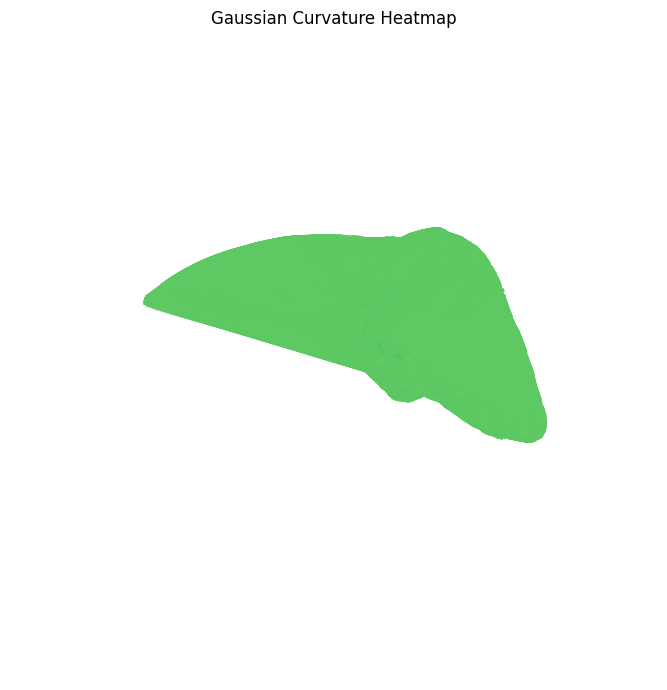

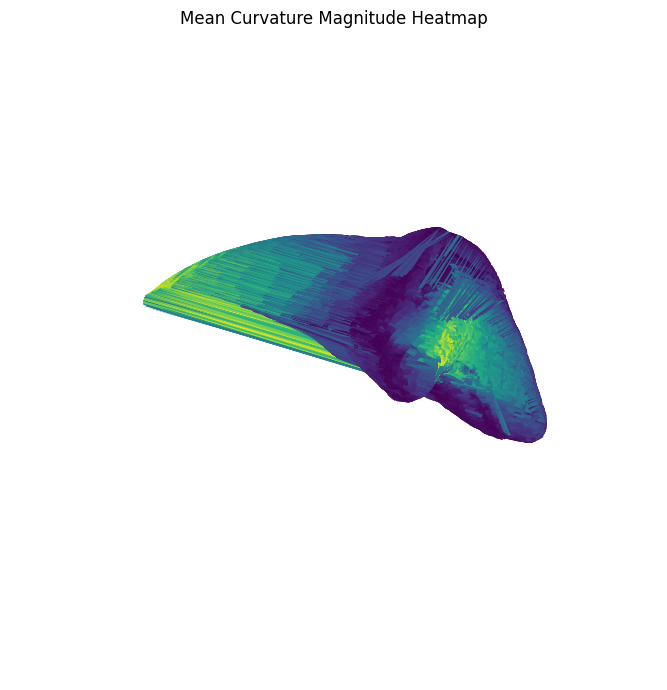

In [37]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

def plot_color_surface(V, F, values, title):
    # ---- Compute per-face values ----
    face_vals = values[F].mean(axis=1)
    c = (face_vals - face_vals.min()) / (face_vals.max() - face_vals.min() + 1e-12)
    face_colors = cm.viridis(c)

    # ---- Build face geometry ----
    faces_xyz = V[F]  # shape (n_faces, 3, 3)

    # ---- Plot ----
    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(111, projection='3d')

    poly = Poly3DCollection(faces_xyz, facecolors=face_colors, linewidth=0.0)
    poly.set_edgecolor((0, 0, 0, 0))  # fully transparent edges
    ax.add_collection3d(poly)

    # autoscale
    ax.auto_scale_xyz(V[:, 0], V[:, 1], V[:, 2])
    ax.set_title(title)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()


# ---- Run it ----
plot_color_surface(V30, F30, K_gauss, "Gaussian Curvature Heatmap")
plot_color_surface(V30, F30, H_mean_mag, "Mean Curvature Magnitude Heatmap")

Delaunay faces: (40345, 3)


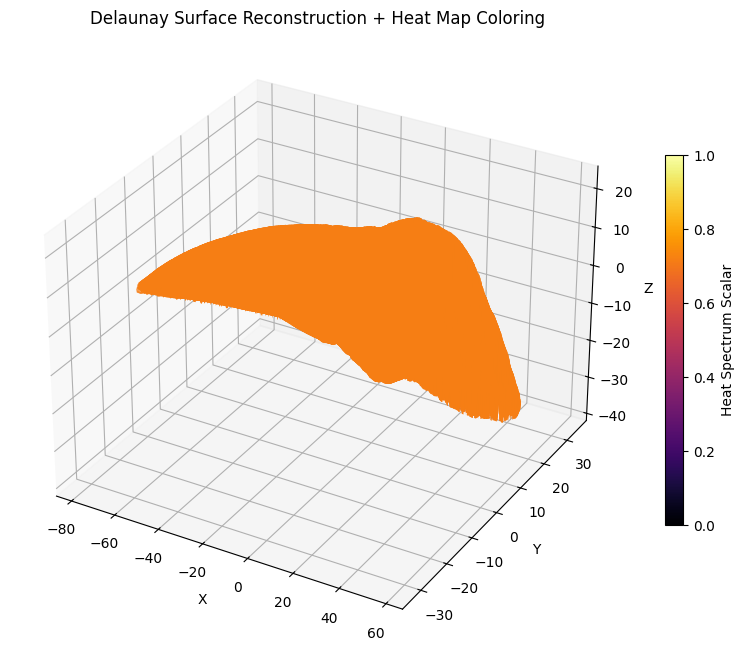

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from mpl_toolkits.mplot3d import Axes3D

# -----------------------------
# 使用 Delaunay 在 XY 平面重新构造三角网格
# -----------------------------
xy = V30[:, :2]               # 只用 xy 投影做 2D Delaunay
tri = Delaunay(xy)
F_delaunay = tri.simplices    # (M,3) 新的三角面

print("Delaunay faces:", F_delaunay.shape)

# -----------------------------
# 准备颜色标量（你可以使用 K_gauss 或 H_mean_mag）
# 例：按曲率着色
# -----------------------------
# scalar = K_gauss                # 如果你有高斯曲率
# scalar = H_mean_mag             # 如果你有平均曲率
scalar = np.linalg.norm(V30, axis=1)   # 例：按点半径着色 (默认)

# 归一化到 [0,1]
scalar_norm = (scalar - scalar.min()) / (scalar.max() - scalar.min())

# -----------------------------
# 绘制带 heat colormap 的 Delaunay 曲面
# -----------------------------
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

trisurf = ax.plot_trisurf(
    V30[:, 0], V30[:, 1], V30[:, 2],
    triangles=F_delaunay,
    cmap="inferno",           # 🔥 heat spectrum
    antialiased=True,
    linewidth=0.0,
    edgecolor='none',
    shade=False,              # 关掉 shade，否则 colormap 会被 wash-out
    alpha=1.0
)

# 将顶点颜色映射到 trisurf
trisurf.set_array(scalar_norm)
trisurf.autoscale()

ax.set_title("Delaunay Surface Reconstruction + Heat Map Coloring")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.colorbar(trisurf, ax=ax, shrink=0.6, label="Heat Spectrum Scalar")
plt.show()